# Libraries Installations 

In [1]:
!pip install geopandas rasterio shapely pyproj torchmetrics leafmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.1/568.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━

# **Earth Observation Delhi-NCR Analysis Pipeline**
### *Land Use Classification using Sentinel-2 RGB and ESA WorldCover*

## Importing necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from pathlib import Path
import warnings
import shutil
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.transform import from_bounds as transform_from_bounds
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import pyproj
from functools import partial

# Machine learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Image processing
from PIL import Image
import cv2
from collections import Counter

# Set device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# File paths
BASE_PATH = "/kaggle/input/earth-observation-delhi-airshed"
RGB_PATH = f"{BASE_PATH}/rgb"
NCR_GEOJSON = f"{BASE_PATH}/delhi_ncr_region.geojson"
AIRSHED_GEOJSON = f"{BASE_PATH}/delhi_airshed.geojson"
LANDCOVER_TIF = f"{BASE_PATH}/worldcover_bbox_delhi_ncr_2021.tif"

print("Data paths are configured")
print(f"RGB images: {RGB_PATH}")
print(f"NCR GeoJSON: {NCR_GEOJSON}")
print(f"Land cover TIF: {LANDCOVER_TIF}")


Using device: cuda
Data paths are configured
RGB images: /kaggle/input/earth-observation-delhi-airshed/rgb
NCR GeoJSON: /kaggle/input/earth-observation-delhi-airshed/delhi_ncr_region.geojson
Land cover TIF: /kaggle/input/earth-observation-delhi-airshed/worldcover_bbox_delhi_ncr_2021.tif


# **Q1: SPATIAL REASONING & DATA FILTERING**

Delhi-NCR GeoDataFrame loaded: EPSG:4326
NCR bounds:          minx       miny       maxx       maxy
0   76.113972  27.054583  77.210751  28.221615
1   77.131414  28.776643  77.504502  29.298148
2   76.879722  26.706062  77.762977  27.823758
3   77.621590  28.059198  78.477477  28.715356
4   77.167901  28.571167  77.303197  28.788141
5   77.297094  28.085117  77.737919  28.654443
6   77.199130  28.607695  77.709528  28.927780
7   77.544371  28.549538  78.212175  28.883855
8   77.422611  28.736682  78.123858  29.266484
9   77.277119  29.184941  78.114839  29.714484
10  77.050629  28.483932  77.256066  28.646095
11  77.216027  28.670071  77.298273  28.786533
12  76.941891  28.656122  77.185831  28.818183
13  77.249939  28.640011  77.332922  28.713984
14  77.083948  29.264866  77.502334  29.697280
15  77.200160  28.480652  77.347570  28.608668
16  75.473396  28.383045  76.365349  29.081344
17  77.149250  28.200428  77.507073  28.513244
18  76.650287  28.199004  77.241868  28.541407
19  76.

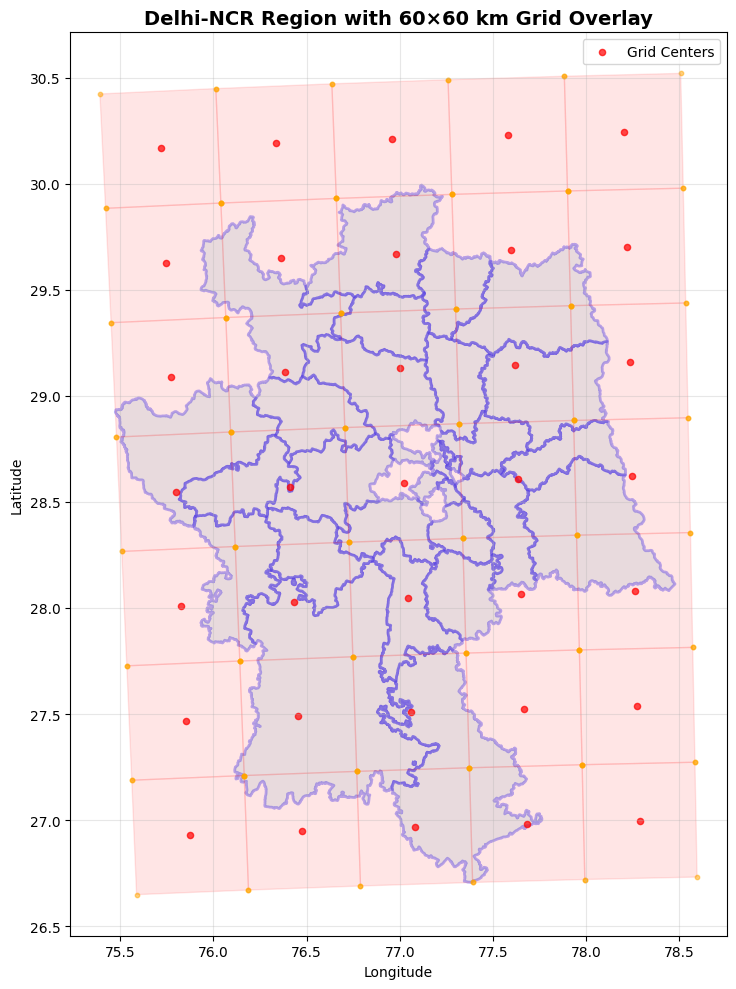


Total RGB images found: 9216
Images before filtering: 9216
Images after filtering: 9216
Filtering retained: 100.0% of images


In [3]:
# Load Delhi-NCR shapefile
ncr_gdf = gpd.read_file(NCR_GEOJSON)
print(f"Delhi-NCR GeoDataFrame loaded: {ncr_gdf.crs}")
print(f"NCR bounds: {ncr_gdf.bounds}")

# Convert to UTM for metric calculations (EPSG:32644)
ncr_utm = ncr_gdf.to_crs('EPSG:32644')
min_x, min_y, max_x, max_y = ncr_utm.total_bounds
print(f"NCR bounds in UTM: minx={min_x}, miny={min_y}, maxx={max_x}, maxy={max_y}")


# Create 60x60 km uniform grid
grid_size = 60000  # 60 km in meters


# Calculate grid dimensions
grid_width = int(np.ceil((max_x - min_x) / grid_size))
grid_height = int(np.ceil((max_y - min_y) / grid_size))

print(f"Grid dimensions: {grid_width} x {grid_height}")

# Create grid polygons
grid_polygons = []
grid_centers = []
grid_corners = []

for i in range(grid_width):
    for j in range(grid_height):
        # Grid cell bounds
        left = min_x + i * grid_size
        right = min_x + (i + 1) * grid_size
        bottom = min_y + j * grid_size
        top = min_y + (j + 1) * grid_size
        
        # Create polygon
        polygon = Polygon([(left, bottom), (right, bottom), (right, top), (left, top)])
        grid_polygons.append(polygon)
        
        # Center point
        center_x = (left + right) / 2
        center_y = (bottom + top) / 2
        grid_centers.append((center_x, center_y))
        
        # Corner points
        corners = [(left, bottom), (right, bottom), (right, top), (left, top)]
        grid_corners.append(corners)

# Create GeoDataFrame for grid
grid_gdf = gpd.GeoDataFrame(geometry=grid_polygons, crs='EPSG:32644')
grid_gdf_wgs84 = grid_gdf.to_crs('EPSG:4326')

# Convert centers and corners to WGS84
transformer = pyproj.Transformer.from_crs('EPSG:32644', 'EPSG:4326', always_xy=True)

centers_wgs84 = []
corners_wgs84 = []

for center in grid_centers:
    lon, lat = transformer.transform(center[0], center[1])
    centers_wgs84.append((lon, lat))

for corner_set in grid_corners:
    corners_transformed = []
    for corner in corner_set:
        lon, lat = transformer.transform(corner[0], corner[1])
        corners_transformed.append((lon, lat))
    corners_wgs84.append(corners_transformed)

# Plot Delhi-NCR with grid overlay
fig, ax = plt.subplots(figsize=(12, 10))

# Plot NCR region
ncr_gdf.plot(ax=ax, alpha=0.3, color='lightblue', edgecolor='blue', linewidth=2)

# Plot grid
grid_gdf_wgs84.plot(ax=ax, alpha=0.1, color='red', edgecolor='red', linewidth=1)

# Plot grid centers
centers_df = pd.DataFrame(centers_wgs84, columns=['lon', 'lat'])
ax.scatter(centers_df['lon'], centers_df['lat'], c='red', s=20, alpha=0.7, label='Grid Centers')

# Plot grid corners
for corners in corners_wgs84:
    corners_df = pd.DataFrame(corners, columns=['lon', 'lat'])
    ax.scatter(corners_df['lon'], corners_df['lat'], c='orange', s=10, alpha=0.5)

ax.set_title('Delhi-NCR Region with 60×60 km Grid Overlay', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Get list of all RGB images BEFORE using them in leafmap
rgb_files = []
if os.path.exists(RGB_PATH):
    rgb_files = [f for f in os.listdir(RGB_PATH) if f.endswith('.png')]
else:
    print(f"Warning: RGB path {RGB_PATH} does not exist")

print(f"\nTotal RGB images found: {len(rgb_files)}")

# Extract coordinates from filenames
def extract_coordinates(filename):
    """Extract lat, lon from filename like '28.2056_76.8558.png'"""
    name = filename.replace('.png', '')
    parts = name.split('_')
    if len(parts) == 2:
        try:
            lat = float(parts[0])
            lon = float(parts[1])
            return lat, lon
        except ValueError:
            return None, None
    return None, None

# Filter images based on grid intersection
filtered_images = []
image_coordinates = []

for filename in rgb_files:
    lat, lon = extract_coordinates(filename)
    if lat is not None and lon is not None:
        point = Point(lon, lat)
        
        # Check if point falls within any grid cell
        for idx, grid_cell in enumerate(grid_gdf_wgs84.geometry):
            if grid_cell.contains(point):
                filtered_images.append(filename)
                image_coordinates.append((lat, lon))
                break

print(f"Images before filtering: {len(rgb_files)}")
print(f"Images after filtering: {len(filtered_images)}")
if len(rgb_files) > 0:
    print(f"Filtering retained: {len(filtered_images)/len(rgb_files)*100:.1f}% of images")

## Interactive Map with leafmap

In [11]:
import leafmap.foliumap as leafmap
import folium
from IPython.display import display

# Calculate center of Delhi NCR region for initial map view
ncr_bounds = ncr_gdf.total_bounds
center_lat = (ncr_bounds[1] + ncr_bounds[3]) / 2
center_lon = (ncr_bounds[0] + ncr_bounds[2]) / 2

print(f"Map center: ({center_lat:.4f}, {center_lon:.4f})")

# Initialize the map
m = leafmap.Map(
    center=[center_lat, center_lon], 
    zoom=9,
    height=600,
    width=1000
)

# Add satellite basemap
m.add_basemap("SATELLITE")

# Add Delhi NCR region boundary
m.add_gdf(
    ncr_gdf, 
    layer_name="Delhi NCR Region",
    style={
        'color': 'blue',
        'weight': 3,
        'fillColor': 'lightblue',
        'fillOpacity': 0.3
    }
)

# Add grid overlay
m.add_gdf(
    grid_gdf_wgs84,
    layer_name="60×60 km Grid",
    style={
        'color': 'red',
        'weight': 2,
        'fillColor': 'red',
        'fillOpacity': 0.1
    }
)

# Add center markers for each grid cell
print(f"Adding {len(centers_wgs84)} grid center markers...")
for idx, (lon, lat) in enumerate(centers_wgs84):
    m.add_marker(
        location=[lat, lon],
        popup=f"Grid Cell {idx + 1}<br>Center: ({lat:.4f}, {lon:.4f})",
        tooltip=f"Grid Center {idx + 1}",
        icon=folium.Icon(color='red', icon='crosshairs', prefix='fa')
    )

# Add corner markers for each grid cell
print(f"Adding corner markers for {len(corners_wgs84)} grid cells...")
for grid_idx, corner_set in enumerate(corners_wgs84):
    for corner_idx, (lon, lat) in enumerate(corner_set):
        m.add_marker(
            location=[lat, lon],
            popup=f"Grid {grid_idx + 1} - Corner {corner_idx + 1}<br>({lat:.4f}, {lon:.4f})",
            tooltip=f"Grid {grid_idx + 1} Corner {corner_idx + 1}",
            icon=folium.Icon(color='orange', icon='map-pin', prefix='fa')
        )

# Add layer control
m.add_layer_control()

# Add legend
legend_html = f'''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 140px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px; border-radius: 5px;
            box-shadow: 0 0 15px rgba(0,0,0,0.2);
            ">
<p><b>Delhi NCR Analysis</b></p>
<p><i class="fa fa-square" style="color:blue"></i> Delhi NCR Region</p>
<p><i class="fa fa-square" style="color:red"></i> 60×60 km Grid</p>
<p><i class="fa fa-crosshairs" style="color:red"></i> Grid Centers</p>
<p><i class="fa fa-map-pin" style="color:orange"></i> Grid Corners</p>
<p><small>Total Images: {len(rgb_files)}</small></p>
<p><small>Filtered Images: {len(filtered_images)}</small></p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50%; transform: translateX(-50%);
            background-color: rgba(255,255,255,0.9); 
            padding: 10px 20px; border-radius: 5px;
            box-shadow: 0 0 15px rgba(0,0,0,0.2);
            z-index:9999; font-size:16px; font-weight:bold;
            ">
Earth Observation Delhi-NCR Analysis - Interactive Grid View
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display summary
print(f"\n🗺️ Interactive Map Summary:")
print(f"- Map centered at: ({center_lat:.4f}, {center_lon:.4f})")
print(f"- Delhi NCR region boundary: ✓")
print(f"- Grid overlay: {len(grid_gdf_wgs84)} cells ✓")
print(f"- Grid centers: {len(centers_wgs84)} markers ✓")
print(f"- Grid corners: {sum(len(corners) for corners in corners_wgs84)} markers ✓")
print(f"- Satellite basemap: ✓")

# Display the map
display(m)

Map center: (28.3498, 76.9754)
Adding 35 grid center markers...
Adding corner markers for 35 grid cells...

🗺️ Interactive Map Summary:
- Map centered at: (28.3498, 76.9754)
- Delhi NCR region boundary: ✓
- Grid overlay: 35 cells ✓
- Grid centers: 35 markers ✓
- Grid corners: 140 markers ✓
- Satellite basemap: ✓


# **Q2: LABEL CONSTRUCTION & DATASET PREPARATION**

- Total RGB images: 9216
- Images after spatial filtering: 9216
Land cover raster CRS: EPSG:4326
Land cover bounds: BoundingBox(left=76.84991666666667, bottom=28.2, right=77.65008333333334, top=29.0)
ESA class mapping: {10: 'Tree cover', 20: 'Shrubland', 30: 'Grassland', 40: 'Cropland', 50: 'Built-up', 60: 'Bare/sparse', 70: 'Snow/ice', 80: 'Water', 90: 'Wetland', 95: 'Mangroves', 100: 'Moss/lichen'}
Label encoding: {'Tree cover': 0, 'Shrubland': 1, 'Grassland': 2, 'Cropland': 3, 'Built-up': 4, 'Bare/sparse': 5, 'Snow/ice': 6, 'Water': 7, 'Wetland': 8, 'Mangroves': 9, 'Moss/lichen': 10}
Extracting land cover labels...
Processed 0/9216 images
Processed 1000/9216 images
Processed 2000/9216 images
Processed 3000/9216 images
Processed 4000/9216 images
Processed 5000/9216 images
Processed 6000/9216 images
Processed 7000/9216 images
Processed 8000/9216 images
Processed 9000/9216 images

Valid images with labels: 9216
Labels extracted: 9216

Dataset summary:
              filename  label_id  

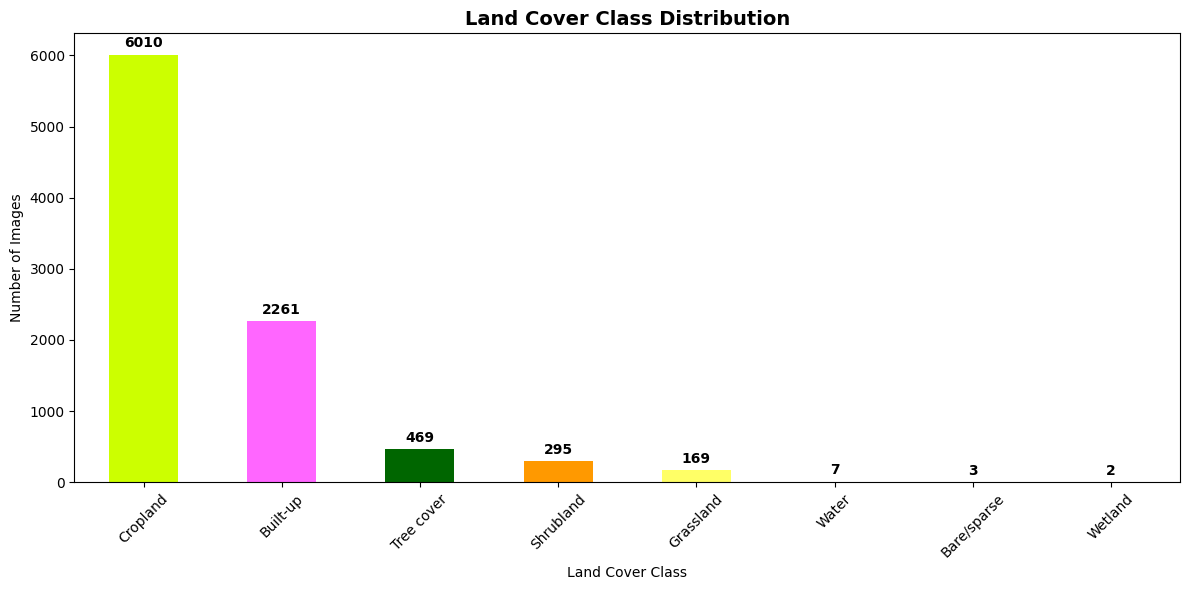

In [4]:
print(f"- Total RGB images: {len(rgb_files)}")
print(f"- Images after spatial filtering: {len(filtered_images)}")

# Load land cover raster
try:
    with rasterio.open(LANDCOVER_TIF) as src:
        landcover_crs = src.crs
        landcover_transform = src.transform
        landcover_bounds = src.bounds
        print(f"Land cover raster CRS: {landcover_crs}")
        print(f"Land cover bounds: {landcover_bounds}")
except Exception as e:
    print(f"Error loading land cover raster: {e}")

# ESA WorldCover class mapping to 11 standardized labels
ESA_CLASS_MAPPING = {
    10: 'Tree cover',
    20: 'Shrubland', 
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare/sparse',
    70: 'Snow/ice',
    80: 'Water',
    90: 'Wetland',
    95: 'Mangroves',
    100: 'Moss/lichen'
}

ESA_CLASS_COLORS = {
    "Moss/lichen": "#f7e084",
    "Mangroves": "#00cc00",
    "Wetland": "#33cccc",
    "Water": "#0000cc",
    "Snow/ice": "#cccccc",
    "Bare/sparse": "#ff0000",
    "Built-up": "#ff66ff",
    "Cropland": "#ccff00",
    "Grassland": "#ffff66",
    "Shrubland": "#ff9900",
    "Tree cover": "#006600"
}

# Create reverse mapping for encoding
LABEL_TO_ID = {label: idx for idx, label in enumerate(ESA_CLASS_MAPPING.values())}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

print(f"ESA class mapping: {ESA_CLASS_MAPPING}")
print(f"Label encoding: {LABEL_TO_ID}")

def extract_landcover_patch(lat, lon, patch_size=128):
    """Extract land cover patch centered at given coordinates"""
    try:
        with rasterio.open(LANDCOVER_TIF) as src:
            # Convert lat/lon to pixel coordinates
            row, col = src.index(lon, lat)
            
            # Calculate patch bounds
            half_size = patch_size // 2
            row_start = max(0, row - half_size)
            row_end = min(src.height, row + half_size)
            col_start = max(0, col - half_size) 
            col_end = min(src.width, col + half_size)
            
            # Read patch
            patch = src.read(1, window=((row_start, row_end), (col_start, col_end)))
            
            # Pad if necessary to ensure 128x128
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                padded_patch = np.full((patch_size, patch_size), 0, dtype=patch.dtype)
                h, w = patch.shape
                padded_patch[:h, :w] = patch
                patch = padded_patch
            
            return patch
    except Exception as e:
        print(f"Error extracting patch for {lat}, {lon}: {e}")
        return None

def get_dominant_class(patch):
    """Get most frequent non-zero class from patch"""
    if patch is None:
        return None
    
    # Remove no-data pixels (0 values)
    valid_pixels = patch[patch > 0]
    
    if len(valid_pixels) == 0:
        return None
    
    # Get most frequent class
    counter = Counter(valid_pixels)
    dominant_class = counter.most_common(1)[0][0]
    
    return dominant_class


# Extract labels for all filtered images
print("Extracting land cover labels...")
image_labels = []
valid_images = []

for i, filename in enumerate(filtered_images):
    if i % 1000 == 0:
        print(f"Processed {i}/{len(filtered_images)} images")
    
    lat, lon = extract_coordinates(filename)
    if lat is not None and lon is not None:
        patch = extract_landcover_patch(lat, lon)
        dominant_class = get_dominant_class(patch)
        
        if dominant_class is not None and dominant_class in ESA_CLASS_MAPPING:
            label = ESA_CLASS_MAPPING[dominant_class]
            label_id = LABEL_TO_ID[label]
            image_labels.append(label_id)
            valid_images.append(filename)

print(f"\nValid images with labels: {len(valid_images)}")
print(f"Labels extracted: {len(image_labels)}")

# Create dataset DataFrame
dataset_df = pd.DataFrame({
    'filename': valid_images,
    'label_id': image_labels,
    'label_name': [ID_TO_LABEL[label_id] for label_id in image_labels]
})

print("\nDataset summary:")
print(dataset_df.head())

# Class distribution analysis
# Count classes
class_counts = dataset_df['label_name'].value_counts()

print("\nClass distribution (number of images per class):")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Get correct colors in order
plot_colors = [ESA_CLASS_COLORS[label] for label in class_counts.index]

# Plot
plt.figure(figsize=(12, 6))
ax = class_counts.plot(kind='bar', color=plot_colors)

plt.title('Land Cover Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Land Cover Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Add text annotations
for i, v in enumerate(class_counts.values):
    ax.text(i, v + max(class_counts.values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [5]:
# Train-test split (60/40)
X = dataset_df['filename'].values
y = dataset_df['label_id'].values

# Check class distribution for stratification
class_counts = np.bincount(y)
print(f"Class counts: {class_counts}")
print(f"Classes with <2 samples: {np.sum(class_counts < 2)}")

# Filter out classes with only 1 sample for stratified split
# or use regular split if too many classes have insufficient samples
min_samples_per_class = np.min(class_counts[class_counts > 0])
print(f"Minimum samples per class: {min_samples_per_class}")

if min_samples_per_class >= 2:
    # Use stratified split
    print("Using stratified split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
else:
    # Remove classes with only 1 sample or use regular split
    unique_classes, class_counts = np.unique(y, return_counts=True)
    classes_to_keep = unique_classes[class_counts >= 2]
    
    if len(classes_to_keep) >= 2:
        # Filter dataset to keep only classes with >=2 samples
        mask = np.isin(y, classes_to_keep)
        X_filtered = X[mask]
        y_filtered = y[mask]
        
        print(f"Filtering to {len(classes_to_keep)} classes with >=2 samples...")
        print(f"Filtered dataset size: {len(X_filtered)}")
        
        # Try stratified split on filtered data
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered, test_size=0.4, random_state=42, stratify=y_filtered
        )
    else:
        # Fall back to regular random split
        print("Using regular random split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42, shuffle=True
        )

print(f"\nTrain-test split:")
print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")
1
# Create label remapping for consecutive class IDs
unique_labels = np.unique(np.concatenate([y_train, y_test]))
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
reverse_label_mapping = {new_label: old_label for old_label, new_label in label_mapping.items()}

# Apply label remapping
y_train_mapped = np.array([label_mapping[label] for label in y_train])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

print(f"Original labels: {unique_labels}")
print(f"Remapped labels: {np.unique(y_train_mapped)}")
print(f"Label mapping: {label_mapping}")


Class counts: [ 469  295  169 6010 2261    3    0    7    2]
Classes with <2 samples: 1
Minimum samples per class: 2
Using stratified split...

Train-test split:
Training set: 5529 images
Test set: 3687 images
Original labels: [0 1 2 3 4 5 7 8]
Remapped labels: [0 1 2 3 4 5 6 7]
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: 6, 8: 7}


# **Q3: MODEL TRAINING & EVALUATION**

Training batches: 173
Test batches: 116
Number of classes for training: 8
Actual classes in training: ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse', 'Water', 'Wetland']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s] 


Model loaded: ResNet18 with 8 output classes
🚀 Starting model training...
Epoch 1/10, Batch 0/173, Loss: 2.9569
Epoch 1/10, Batch 50/173, Loss: 0.4137
Epoch 1/10, Batch 100/173, Loss: 0.3289
Epoch 1/10, Batch 150/173, Loss: 0.1816
Epoch 1/10:
Train Loss: 0.4822, Train Acc: 84.83%
Val Loss: 0.3841, Val Acc: 85.46%
--------------------------------------------------
Epoch 2/10, Batch 0/173, Loss: 0.3516
Epoch 2/10, Batch 50/173, Loss: 0.2237
Epoch 2/10, Batch 100/173, Loss: 0.5377
Epoch 2/10, Batch 150/173, Loss: 0.3845
Epoch 2/10:
Train Loss: 0.3293, Train Acc: 88.55%
Val Loss: 0.4110, Val Acc: 83.94%
--------------------------------------------------
Epoch 3/10, Batch 0/173, Loss: 0.3390
Epoch 3/10, Batch 50/173, Loss: 0.3901
Epoch 3/10, Batch 100/173, Loss: 0.4383
Epoch 3/10, Batch 150/173, Loss: 0.3174
Epoch 3/10:
Train Loss: 0.2937, Train Acc: 89.96%
Val Loss: 0.3285, Val Acc: 87.36%
--------------------------------------------------
Epoch 4/10, Batch 0/173, Loss: 0.2829
Epoch 4/10, 

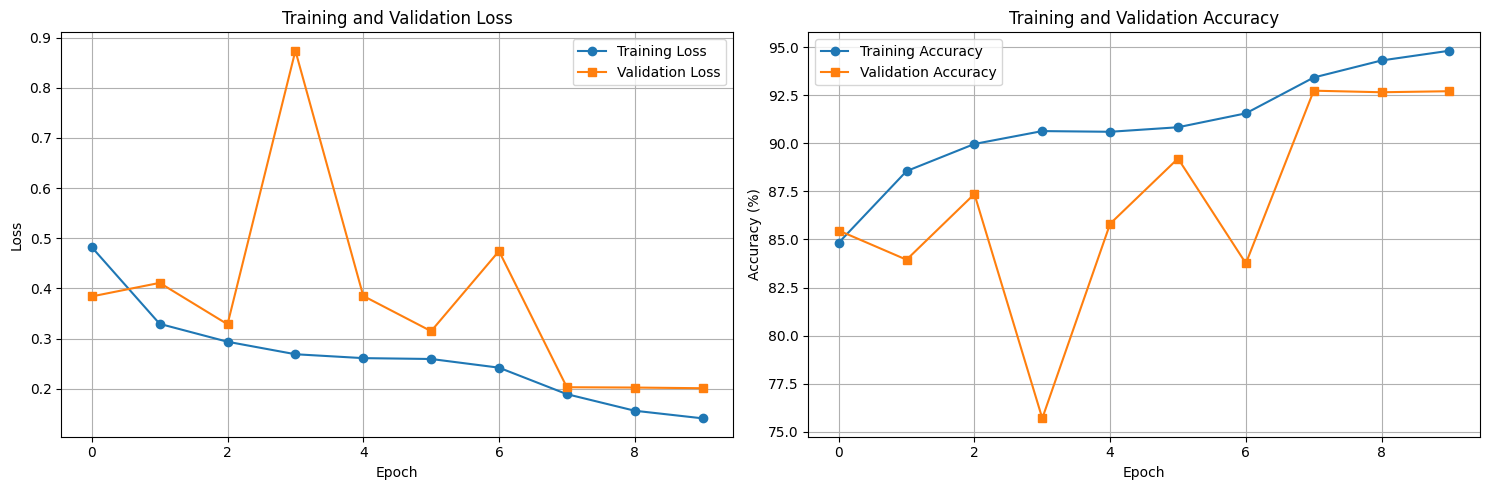


Custom F1 Score (weighted): 0.9253
TorchMetrics F1 Score (weighted): 0.9253


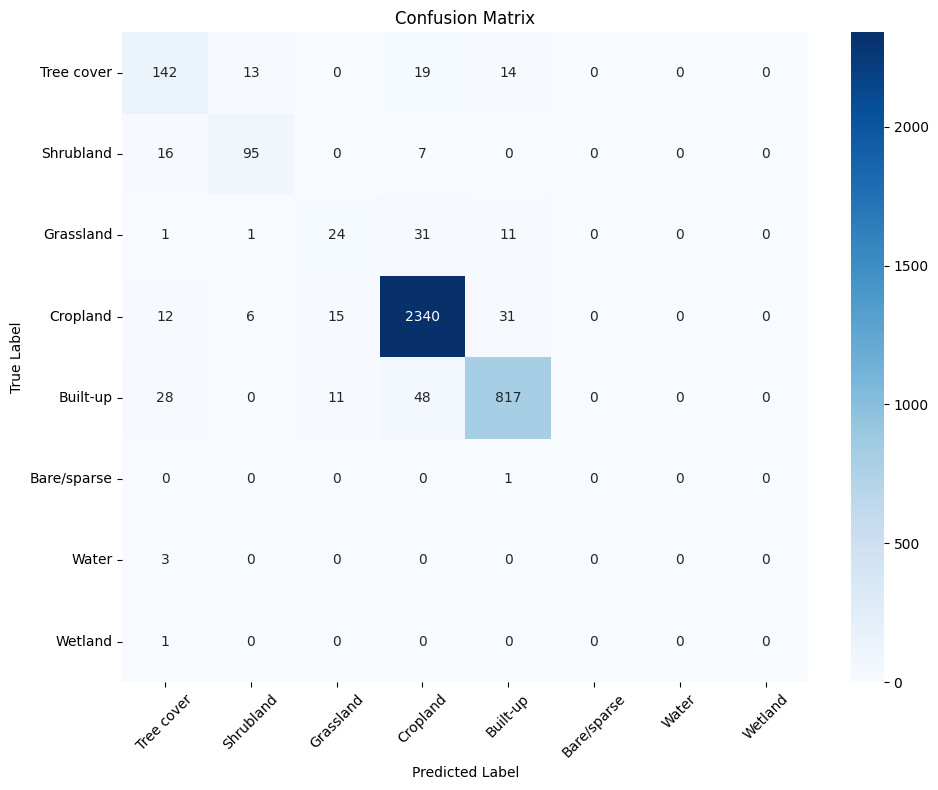


Classification Report:
              precision    recall  f1-score   support

  Tree cover       0.70      0.76      0.73       188
   Shrubland       0.83      0.81      0.82       118
   Grassland       0.48      0.35      0.41        68
    Cropland       0.96      0.97      0.97      2404
    Built-up       0.93      0.90      0.92       904
 Bare/sparse       0.00      0.00      0.00         1
       Water       0.00      0.00      0.00         3
     Wetland       0.00      0.00      0.00         1

    accuracy                           0.93      3687
   macro avg       0.49      0.47      0.48      3687
weighted avg       0.92      0.93      0.93      3687



In [6]:
# Custom Dataset class
class LandCoverDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(RGB_PATH, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with remapped labels
train_dataset = LandCoverDataset(X_train, y_train_mapped, transform=train_transform)
test_dataset = LandCoverDataset(X_test, y_test_mapped, transform=test_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Define model
num_classes = len(unique_labels)
print(f"Number of classes for training: {num_classes}")

# Create class name mapping for display
actual_id_to_label = {new_id: ID_TO_LABEL[old_id] for new_id, old_id in reverse_label_mapping.items()}
print(f"Actual classes in training: {[actual_id_to_label[i] for i in range(num_classes)]}")

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

print(f"Model loaded: ResNet18 with {num_classes} output classes")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, num_epochs=15):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        scheduler.step()
    
    return train_losses, val_losses, train_accs, val_accs

# Train the model
print("🚀 Starting model training...")
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, num_epochs=10)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Training Loss', marker='o')
ax1.plot(val_losses, label='Validation Loss', marker='s')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy', marker='o')
ax2.plot(val_accs, label='Validation Accuracy', marker='s')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Custom F1 Score implementation
def custom_f1_score(y_true, y_pred, average='weighted'):
    """Custom F1 score implementation"""
    classes = np.unique(y_true)
    f1_scores = []
    
    for cls in classes:
        # Calculate precision and recall for each class
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    if average == 'weighted':
        weights = [np.sum(y_true == cls) for cls in classes]
        return np.average(f1_scores, weights=weights)
    elif average == 'macro':
        return np.mean(f1_scores)
    else:
        return f1_scores

# Evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# Custom F1 score
custom_f1 = custom_f1_score(y_true, y_pred, average='weighted')
print(f"\nCustom F1 Score (weighted): {custom_f1:.4f}")

# TorchMetrics F1 score
f1_metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='weighted')
f1_metric = f1_metric.to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        f1_metric.update(preds, labels)

torchmetrics_f1 = f1_metric.compute()
print(f"TorchMetrics F1 Score (weighted): {torchmetrics_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = [actual_id_to_label[i] for i in range(num_classes)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📊 Sample Predictions:


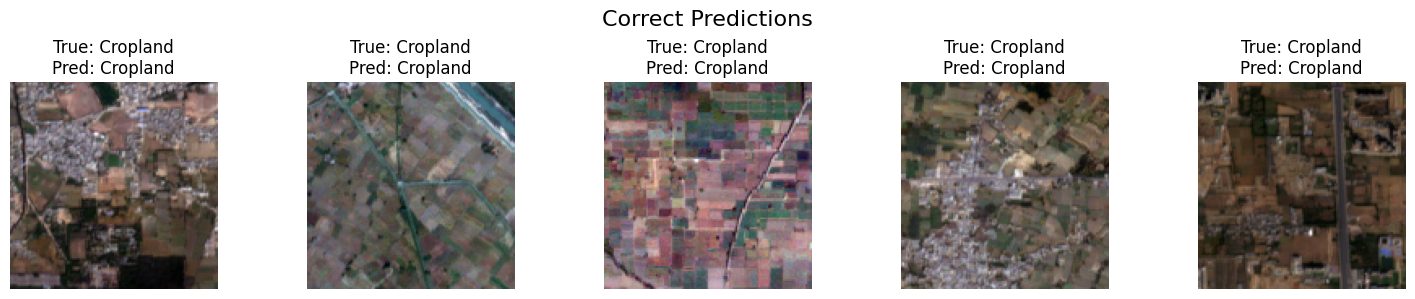

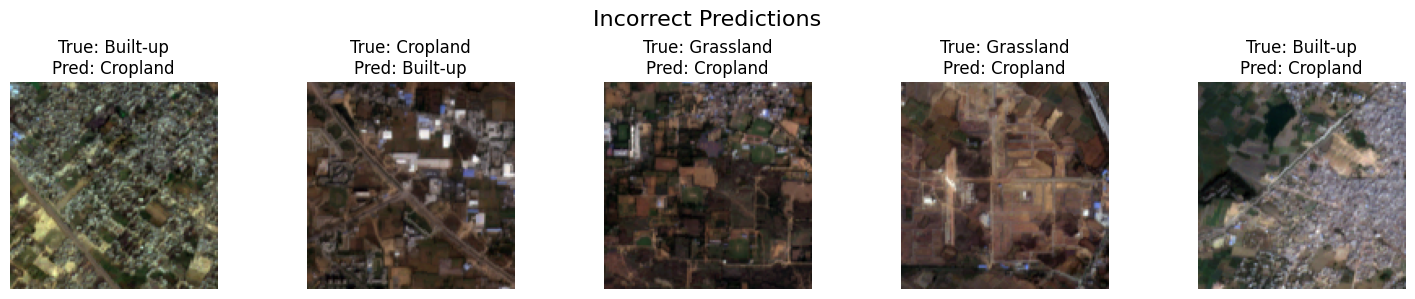


 PIPELINE COMPLETED SUCCESSFULLY!

Summary:
- Total images processed: 9216
- Images after spatial filtering: 9216
- Final dataset size: 9216
- Training set: 5529
- Test set: 3687
- Number of classes: 8
- Final F1 Score: 0.9253


In [7]:
# Plot sample predictions
def plot_sample_predictions(model, dataset, num_samples=5, correct=True):
    """Plot sample predictions"""
    model.eval()
    samples = []
    
    with torch.no_grad():
        for i, (image, label) in enumerate(dataset):
            if len(samples) >= num_samples:
                break
                
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            
            is_correct = (predicted.item() == label.item())
            
            if (correct and is_correct) or (not correct and not is_correct):
                # Denormalize image for display
                image_np = image.squeeze().cpu().numpy()
                image_np = np.transpose(image_np, (1, 2, 0))
                
                # Denormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = image_np * std + mean
                image_np = np.clip(image_np, 0, 1)
                
                samples.append({
                    'image': image_np,
                    'true_label': actual_id_to_label[label.item()],
                    'pred_label': actual_id_to_label[predicted.item()],
                    'correct': is_correct
                })
    
    # Plot samples
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
    if len(samples) == 1:
        axes = [axes]
    
    for i, sample in enumerate(samples):
        axes[i].imshow(sample['image'])
        axes[i].set_title(f"True: {sample['true_label']}\nPred: {sample['pred_label']}")
        axes[i].axis('off')
    
    plt.suptitle(f"{'Correct' if correct else 'Incorrect'} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot correct and incorrect predictions
print("\n📊 Sample Predictions:")
plot_sample_predictions(model, test_dataset, num_samples=5, correct=True)
plot_sample_predictions(model, test_dataset, num_samples=5, correct=False)

print("\n PIPELINE COMPLETED SUCCESSFULLY!")
print("\nSummary:")
print(f"- Total images processed: {len(rgb_files)}")
print(f"- Images after spatial filtering: {len(filtered_images)}")
print(f"- Final dataset size: {len(valid_images)}")
print(f"- Training set: {len(X_train)}")
print(f"- Test set: {len(X_test)}")
print(f"- Number of classes: {num_classes}")
print(f"- Final F1 Score: {custom_f1:.4f}")

In [8]:
# After training, save both model and metadata
model_info = {
    'state_dict': model.state_dict(),
    'num_classes': num_classes,
    'class_mapping': actual_id_to_label,
    'label_mapping': label_mapping
}
torch.save(model_info, 'landcover_model.pth')

In [9]:
# Calculate no-data pixel stats
nodata_ratios = []

for filename in filtered_images:
    lat, lon = extract_coordinates(filename)
    patch = extract_landcover_patch(lat, lon)
    if patch is not None:
        total_pixels = patch.size
        nodata_pixels = np.sum(patch == 0)
        nodata_ratio = (nodata_pixels / total_pixels) * 100
        nodata_ratios.append(nodata_ratio)

avg_nodata = np.mean(nodata_ratios)
num_patches_10 = np.sum(np.array(nodata_ratios) > 10)
num_patches_50 = np.sum(np.array(nodata_ratios) > 50)

print("\nNO-DATA PIXEL ANALYSIS:")
print(f"- Average no-data pixels per patch: {avg_nodata:.2f}%")
print(f"- Patches with >10% no-data pixels: {num_patches_10}")
print(f"- Patches with >50% no-data pixels: {num_patches_50}")



NO-DATA PIXEL ANALYSIS:
- Average no-data pixels per patch: 0.00%
- Patches with >10% no-data pixels: 0
- Patches with >50% no-data pixels: 0


Loading airshed polygon...
Original CRS: EPSG:4326
Polygon bounds: [76.85 28.2  77.65 29.  ]
Masking raster with airshed polygon...
Raster CRS: EPSG:4326
Raster shape: (9600, 9602)
Raster bounds: BoundingBox(left=76.84991666666667, bottom=28.2, right=77.65008333333334, top=29.0)
Masked raster shape: (9600, 9601)
Unique values in masked data: [ 0 10 20 30 40 50 60 80 90]
Analyzing land cover distribution...
Total valid pixels: 92,160,000
Tree cover: 9,595,025 pixels (10.41%)
Shrubland: 3,073,217 pixels (3.33%)
Grassland: 6,558,691 pixels (7.12%)
Cropland: 49,313,882 pixels (53.51%)
Built-up: 21,435,664 pixels (23.26%)
Bare/sparse vegetation: 1,547,683 pixels (1.68%)
Permanent water bodies: 599,996 pixels (0.65%)
Herbaceous wetland: 35,842 pixels (0.04%)
Creating percentage plot...


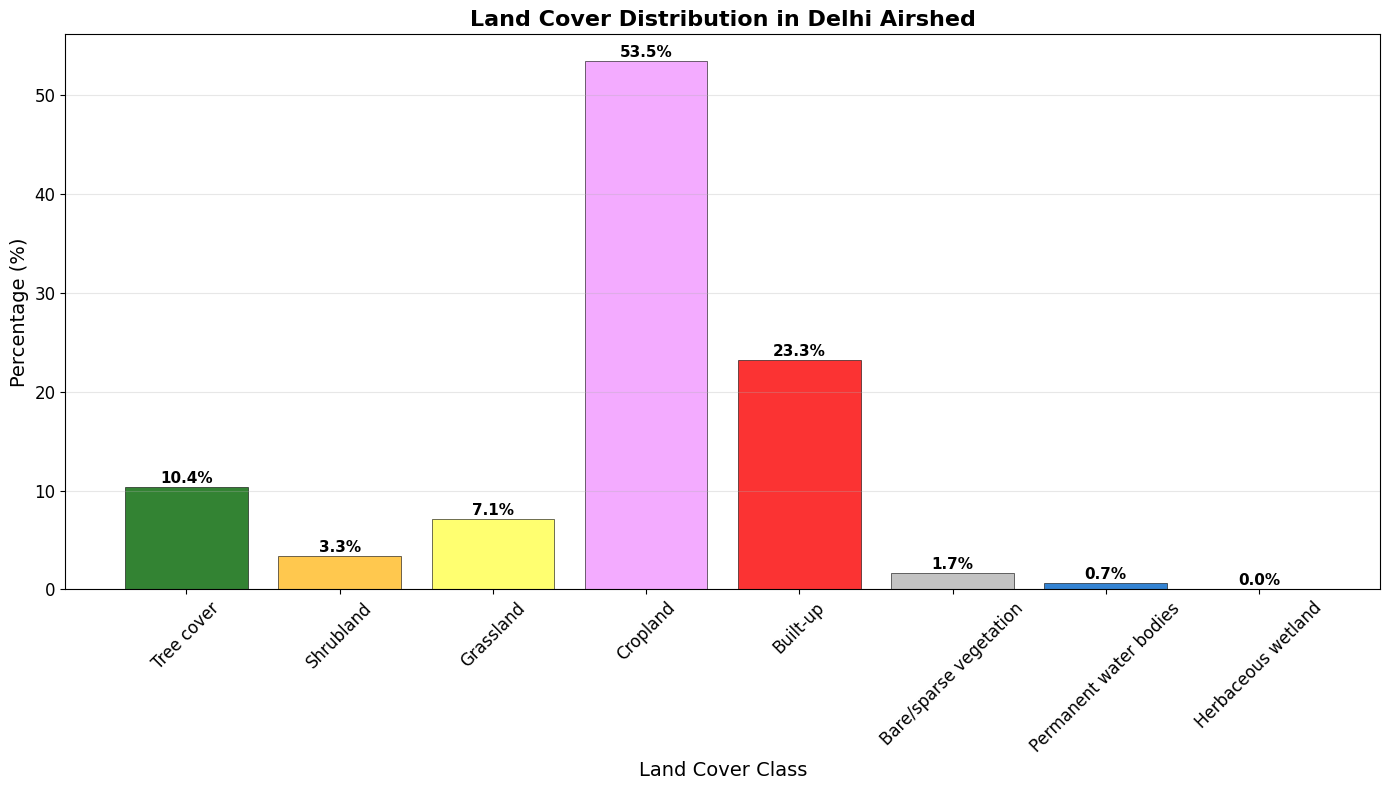

Creating color-coded land cover map...


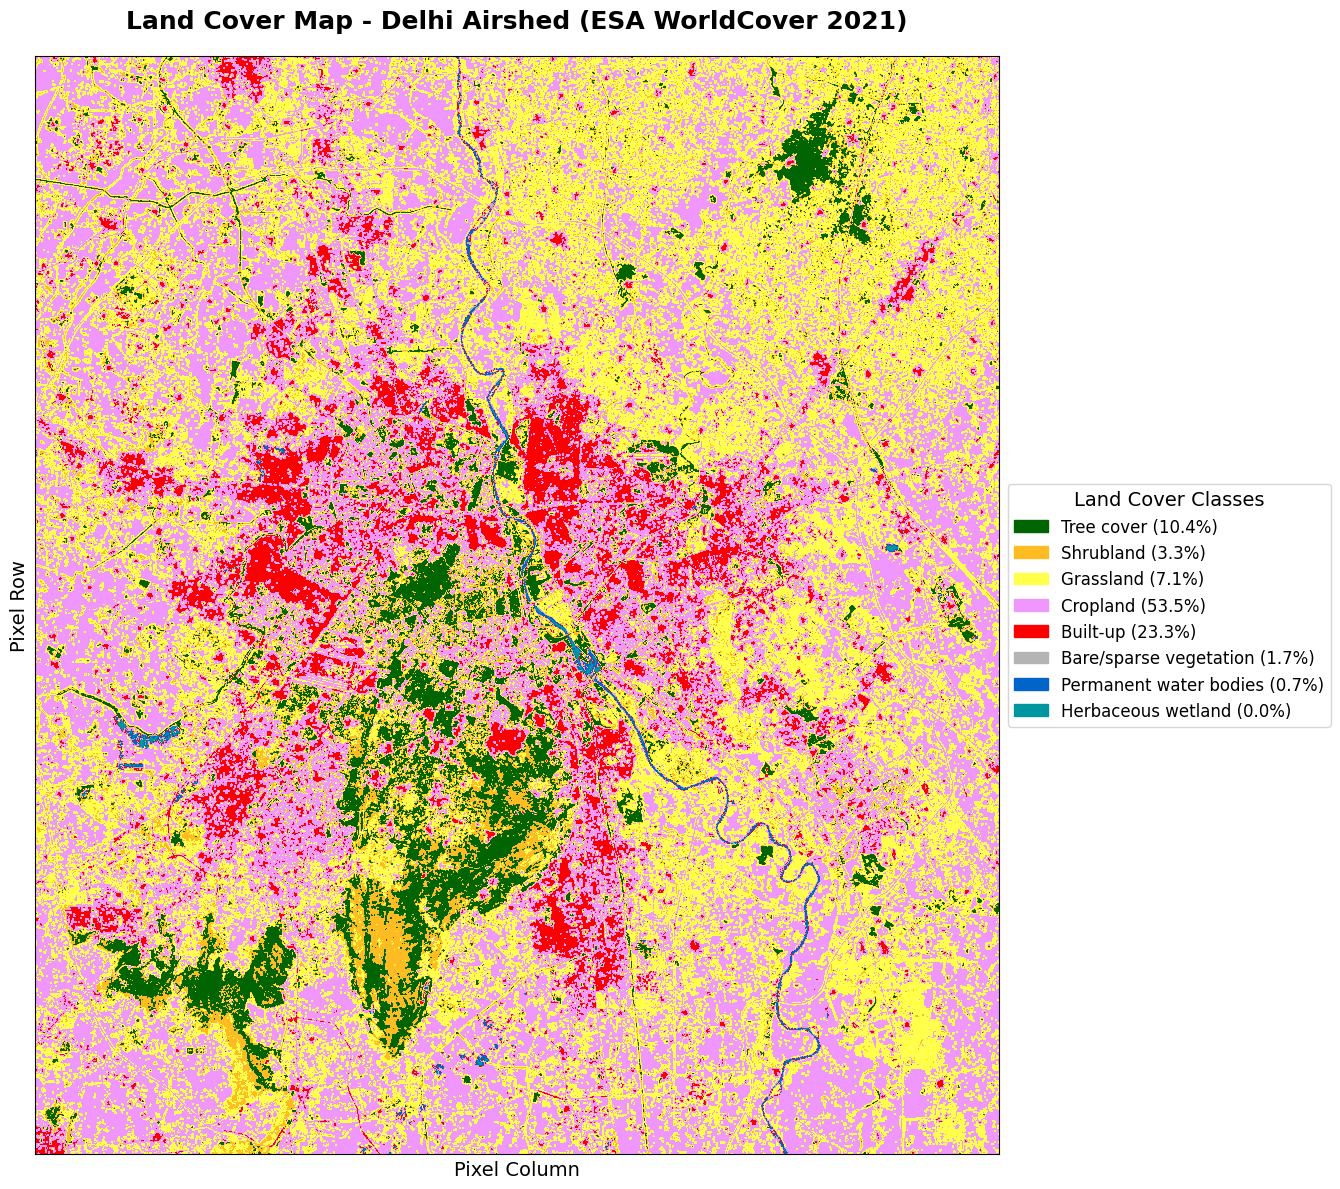

Creating summary table...

LAND COVER ANALYSIS SUMMARY - DELHI AIRSHED
Total analyzed pixels: 92,160,000
Total area: 9216.00 km²

Detailed Breakdown:
 ESA_Code       Land_Cover_Class  Pixel_Count  Percentage  Area_km2
       40               Cropland     49313882       53.51   4931.39
       50               Built-up     21435664       23.26   2143.57
       10             Tree cover      9595025       10.41    959.50
       30              Grassland      6558691        7.12    655.87
       20              Shrubland      3073217        3.33    307.32
       60 Bare/sparse vegetation      1547683        1.68    154.77
       80 Permanent water bodies       599996        0.65     60.00
       90     Herbaceous wetland        35842        0.04      3.58

Analysis completed successfully!
Found 8 land cover classes in the Delhi airshed

Key Findings:
1. Total area analyzed: 9216.00 km²
2. Number of land cover classes: 8
3. Dominant land cover: Cropland
4. Urban area (Built-up): 23.3%
5. Ag

In [10]:
# ESA WorldCover 2021 land cover classes and their official colors
ESA_CLASSES = {
    10: {'name': 'Tree cover', 'color': '#006400'},
    20: {'name': 'Shrubland', 'color': '#FFBB22'},
    30: {'name': 'Grassland', 'color': '#FFFF4C'},
    40: {'name': 'Cropland', 'color': '#F096FF'},
    50: {'name': 'Built-up', 'color': '#FA0000'},
    60: {'name': 'Bare/sparse vegetation', 'color': '#B4B4B4'},
    70: {'name': 'Snow and ice', 'color': '#F0F0F0'},
    80: {'name': 'Permanent water bodies', 'color': '#0064C8'},
    90: {'name': 'Herbaceous wetland', 'color': '#0096A0'},
    95: {'name': 'Mangroves', 'color': '#00CF75'},
    100: {'name': 'Moss and lichen', 'color': '#FAE6A0'}
}

def load_and_reproject_polygon(polygon_path, target_crs):
    """Load polygon and reproject to match raster CRS"""
    print("Loading airshed polygon...")
    gdf = gpd.read_file(polygon_path)
    print(f"Original CRS: {gdf.crs}")
    
    if gdf.crs != target_crs:
        print(f"Reprojecting to: {target_crs}")
        gdf = gdf.to_crs(target_crs)
    
    print(f"Polygon bounds: {gdf.total_bounds}")
    return gdf

def mask_raster_with_polygon(raster_path, polygon_gdf):
    """Mask raster using polygon and return masked data"""
    print("Masking raster with airshed polygon...")
    
    with rasterio.open(raster_path) as src:
        print(f"Raster CRS: {src.crs}")
        print(f"Raster shape: {src.shape}")
        print(f"Raster bounds: {src.bounds}")
        
        # Get polygon geometries
        geometries = polygon_gdf.geometry.values
        
        # Mask the raster
        masked_data, masked_transform = mask(src, geometries, crop=True, nodata=0)
        masked_data = masked_data[0]  # Get first band
        
        # Create profile for masked raster
        masked_profile = src.profile.copy()
        masked_profile.update({
            'height': masked_data.shape[0],
            'width': masked_data.shape[1],
            'transform': masked_transform,
            'nodata': 0
        })
        
        print(f"Masked raster shape: {masked_data.shape}")
        print(f"Unique values in masked data: {np.unique(masked_data)}")
        
        return masked_data, masked_profile

def analyze_landcover_distribution(masked_data):
    """Analyze land cover distribution from masked raster"""
    print("Analyzing land cover distribution...")
    
    # Remove nodata values (0) from analysis
    valid_pixels = masked_data[masked_data != 0]
    total_pixels = len(valid_pixels)
    
    print(f"Total valid pixels: {total_pixels:,}")
    
    # Count pixels per class
    unique_values, counts = np.unique(valid_pixels, return_counts=True)
    
    # Create results dictionary
    results = {}
    for value, count in zip(unique_values, counts):
        if value in ESA_CLASSES:
            class_name = ESA_CLASSES[value]['name']
            percentage = (count / total_pixels) * 100
            results[value] = {
                'class_name': class_name,
                'pixel_count': count,
                'percentage': percentage,
                'color': ESA_CLASSES[value]['color']
            }
            print(f"{class_name}: {count:,} pixels ({percentage:.2f}%)")
    
    return results, total_pixels

# Visualization Functions
def create_percentage_plots(results):
    """Create bar chart of land cover percentages"""
    print("Creating percentage plot...")
    
    # Prepare data for plotting
    classes = [results[key]['class_name'] for key in results.keys()]
    percentages = [results[key]['percentage'] for key in results.keys()]
    colors = [results[key]['color'] for key in results.keys()]
    
    # Create figure with single subplot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Bar chart
    bars = ax.bar(classes, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_title('Land Cover Distribution in Delhi Airshed', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_xlabel('Land Cover Class', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def create_landcover_map(masked_data, masked_profile, results, polygon_gdf):
    """Create color-coded land cover map"""
    print("Creating color-coded land cover map...")
    
    # Create colormap for land cover classes
    class_values = list(results.keys())
    class_colors = [results[key]['color'] for key in class_values]
    
    # Create custom colormap
    cmap = ListedColormap(class_colors)
    
    # Create the map
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Plot the masked raster
    im = ax.imshow(masked_data, cmap=cmap, vmin=min(class_values), vmax=max(class_values))
    
    # Add polygon boundary
    polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=2, alpha=0.8)
    
    # Create legend
    legend_elements = []
    for value in class_values:
        class_info = results[value]
        legend_elements.append(
            patches.Patch(color=class_info['color'], 
                         label=f"{class_info['class_name']} ({class_info['percentage']:.1f}%)")
        )
    
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
              fontsize=12, title='Land Cover Classes', title_fontsize=14)
    
    ax.set_title('Land Cover Map - Delhi Airshed (ESA WorldCover 2021)', 
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Pixel Column', fontsize=14)
    ax.set_ylabel('Pixel Row', fontsize=14)
    
    # Remove axis ticks for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

def create_summary_table(results, total_pixels):
    """Create a summary table of the analysis"""
    print("Creating summary table...")
    
    # Convert results to DataFrame
    data = []
    for value, info in results.items():
        data.append({
            'ESA_Code': value,
            'Land_Cover_Class': info['class_name'],
            'Pixel_Count': info['pixel_count'],
            'Percentage': round(info['percentage'], 2),
            'Area_km2': round((info['pixel_count'] * 100) / 1_000_000, 2)  # 10m pixels = 100 m²
        })
    
    df = pd.DataFrame(data)
    df = df.sort_values('Percentage', ascending=False)
    
    print("\nLAND COVER ANALYSIS SUMMARY - DELHI AIRSHED")
    print(f"Total analyzed pixels: {total_pixels:,}")
    print(f"Total area: {(total_pixels * 100) / 1_000_000:.2f} km²")
    print("\nDetailed Breakdown:")
    print(df.to_string(index=False))
    
    return df

# Main Analysis Function
def main():
    
    # Load and examine the raster to get its CRS
    with rasterio.open(LANDCOVER_TIF) as src:
        raster_crs = src.crs
    
    # Load and reproject polygon
    polygon_gdf = load_and_reproject_polygon(AIRSHED_GEOJSON, raster_crs)
    
    # Mask raster with polygon
    masked_data, masked_profile = mask_raster_with_polygon(LANDCOVER_TIF, polygon_gdf)
    
    # Analyze land cover distribution
    results, total_pixels = analyze_landcover_distribution(masked_data)
    
    # Create visualizations
    create_percentage_plots(results)
    create_landcover_map(masked_data, masked_profile, results, polygon_gdf)
    
    # Create summary table
    summary_df = create_summary_table(results, total_pixels)
    
    print(f"\nAnalysis completed successfully!")
    print(f"Found {len(results)} land cover classes in the Delhi airshed")
    
    return results, summary_df, masked_data, masked_profile

# Run the Analysis
results, summary_df, masked_data, masked_profile = main()

# Display Summary Statistics
print("\nKey Findings:")
print(f"1. Total area analyzed: {(len(masked_data[masked_data != 0]) * 100) / 1_000_000:.2f} km²")
print(f"2. Number of land cover classes: {len(results)}")
print(f"3. Dominant land cover: {max(results.items(), key=lambda x: x[1]['percentage'])[1]['class_name']}")
print(f"4. Urban area (Built-up): {results.get(50, {}).get('percentage', 0):.1f}%")
print(f"5. Agricultural area (Cropland): {results.get(40, {}).get('percentage', 0):.1f}%")
print(f"6. Forest cover (Tree cover): {results.get(10, {}).get('percentage', 0):.1f}%")

